In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy import interp
from os.path import join as path_join

IMAGES_DIR = "Images"

In [8]:
# Creating merged dataframe with genetical score
main_df_n = pd.read_csv('GWAS_clinical.csv')
score_df_n = pd.read_csv('plink_001.csv', delim_whitespace=True)
res_df_n = pd.merge(main_df_n, score_df_n, left_on='FamID', right_on='FID')

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
df = res_df_n.dropna()

# Genetical and non-genetical factors
df_data = df.loc[:, ['sex', 'tg', 'hdl', 'ldl', 'SCORESUM']]
df_target = df.loc[:, 'CAD']

# Only genetical factors
df_gen_data = df.loc[:, ['SCORESUM']]
df_gen_target = df.loc[:, 'CAD']

# Only non-genetical factors
df_non_gen_data = df.loc[:, ['sex', 'tg', 'hdl', 'ldl']]
df_non_gen_target = df.loc[:, 'CAD']

# "Leave one out" or not
leave_one_out = False
if leave_one_out:
    k = len(df)
else:
    k = 10
    
# Splitting data
kfold = StratifiedKFold(k, True, 244)
sp_data = np.array(list(kfold.split(df, df_target)))
sp_gen_data = np.array(list(kfold.split(df, df_gen_target)))
sp_non_gen_data = np.array(list(kfold.split(df, df_non_gen_target)))

In [53]:
def kfold_train_model(model, kfold_split_indexes, df_data, df_target, 
                      name="Unknown model", save_name="unknown", data="all"):
    results = []
    tprs = []
    aucs = []
    
    i = 1
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(8,8))
    
    if data == "all":
        title_data_part = "для всех факторов"
    elif data == "gen":
        title_data_part = "без внешних факторов"
    elif data == "non-gen":
        title_data_part = "без полигенного скора"
    else:
        raise ValueError()
        
    for train_indexes, test_indexes in kfold_split_indexes:
        x_train = df_data.iloc[train_indexes, :]
        y_train = df_target.iloc[train_indexes]
        x_test = df_data.iloc[test_indexes, :]
        y_test =  df_target.iloc[test_indexes]
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        results.append(accuracy_score(y_test, predictions))
        
        predidctions_probs = model.predict_proba(x_test)
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y_test, predidctions_probs[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC-кривая для %d-й итерации (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Случайное предсказание', alpha=0.8)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
    label=r'Средняя ROC-кривая (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Ложно-положительное значение')
    plt.ylabel('Истинно-положительное значение')
    title = "{}: ROC-кривая {}".format(name, title_data_part)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(path_join(IMAGES_DIR, "{}-{}.png".format(save_name, data)))
    return np.array(results)

0.7533801234511384 0.03522601899041005
0.7329443058353171 0.024334465150684957
0.7073081185527681 0.03749993584827246


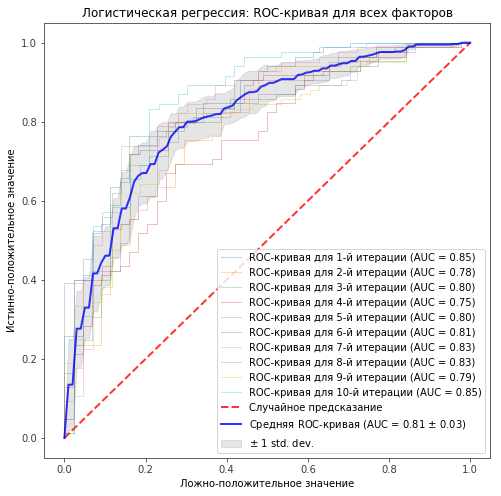

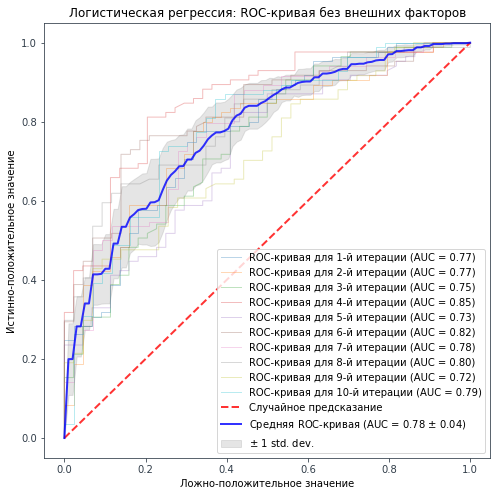

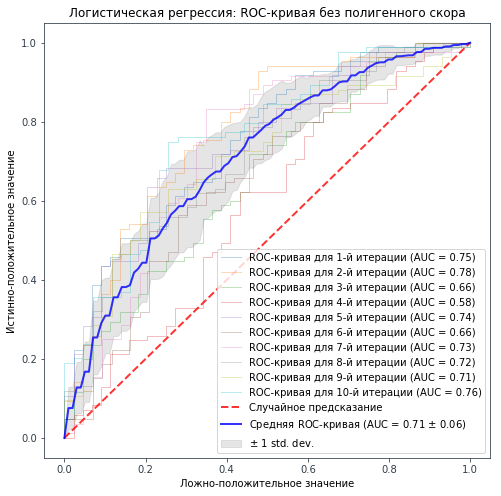

In [55]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
model_name = "Логистическая регрессия"
save_name = "logistic-regression"
log_reg = LogisticRegression(solver='lbfgs')

res = kfold_train_model(log_reg, sp_data, df_data, df_target, name=model_name, save_name=save_name)
res_gen = kfold_train_model(log_reg, sp_gen_data, df_gen_data, df_gen_target, name=model_name, data="gen", save_name=save_name)
res_non_gen = kfold_train_model(log_reg, sp_non_gen_data, df_non_gen_data, df_non_gen_target, name=model_name, data="non-gen", save_name=save_name)

print(res.mean(), res.std())
print(res_gen.mean(), res_gen.std())
print(res_non_gen.mean(), res_non_gen.std())

0.7439921526887627 0.023412128748859135
0.6713012345113837 0.03564930984129182
0.6776433173869255 0.031572221696100876


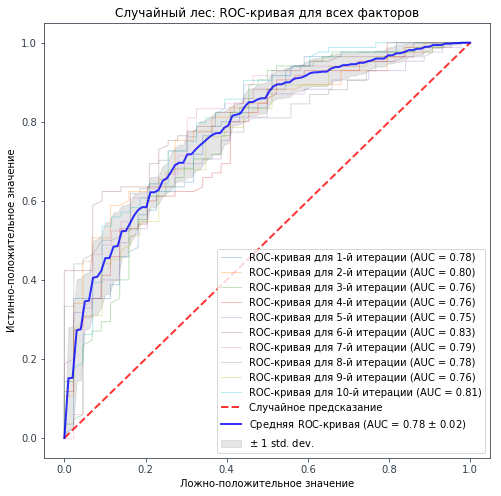

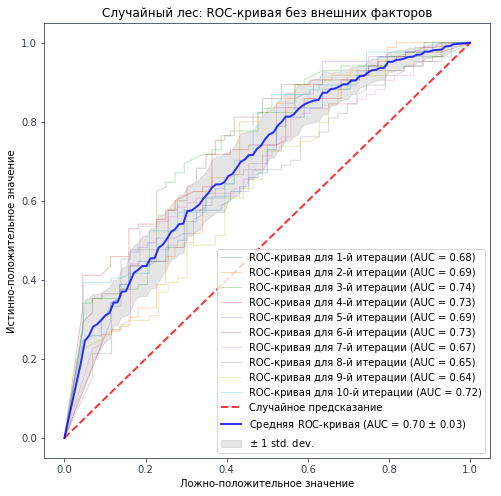

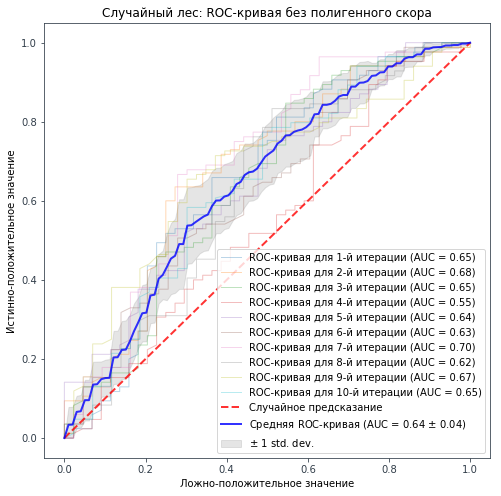

In [56]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
model_name = "Случайный лес"
save_name = "random-forest"
rf = RandomForestClassifier(n_estimators=1000)

res = kfold_train_model(rf, sp_data, df_data, df_target, name=model_name, save_name=save_name)
res_gen = kfold_train_model(rf, sp_gen_data, df_gen_data, df_gen_target, name=model_name, data="gen", save_name=save_name)
res_non_gen = kfold_train_model(rf, sp_non_gen_data, df_non_gen_data, df_non_gen_target, name=model_name, data="non-gen", save_name=save_name)

print(res.mean(), res.std())
print(res_gen.mean(), res_gen.std())
print(res_non_gen.mean(), res_non_gen.std())

0.7581166453030581 0.030061627930207325
0.721255455350058 0.024943828169692817
0.7088343767167186 0.03993482859533695


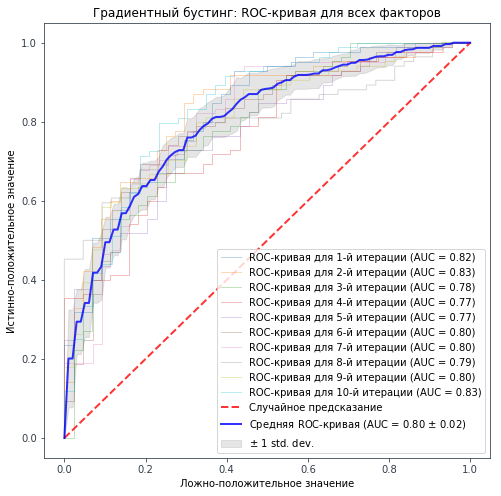

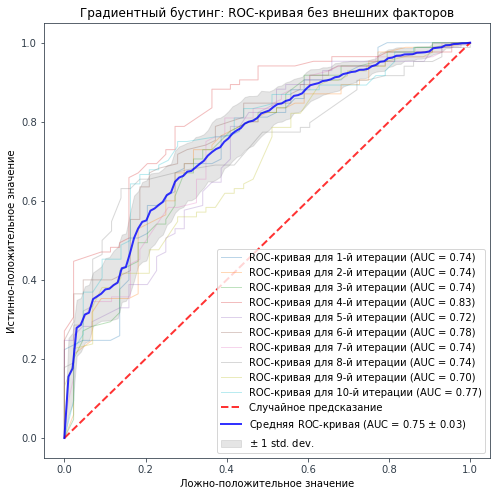

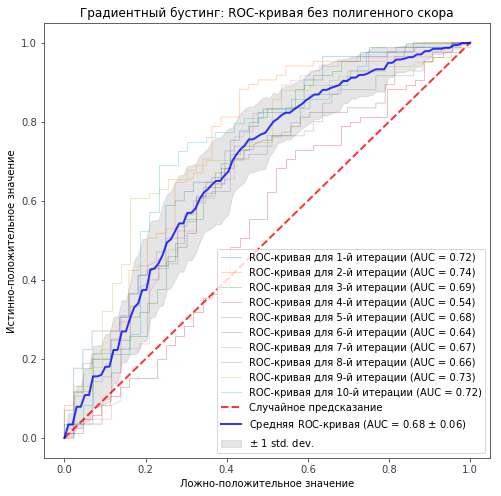

In [57]:
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100)
model_name = "Градиентный бустинг"
save_name = "gradient-boosting"

res = kfold_train_model(gb, sp_data, df_data, df_target, name=model_name, save_name=save_name)
res_gen = kfold_train_model(gb, sp_gen_data, df_gen_data, df_gen_target, name=model_name, data="gen", save_name=save_name)
res_non_gen = kfold_train_model(gb, sp_non_gen_data, df_non_gen_data, df_non_gen_target, name=model_name, data="non-gen", save_name=save_name)

print(res.mean(), res.std())
print(res_gen.mean(), res_gen.std())
print(res_non_gen.mean(), res_non_gen.std())

0.7619681987425991 0.032143204995460674
0.7423624622321918 0.030384524172473462
0.7018454247543184 0.044465499875829484


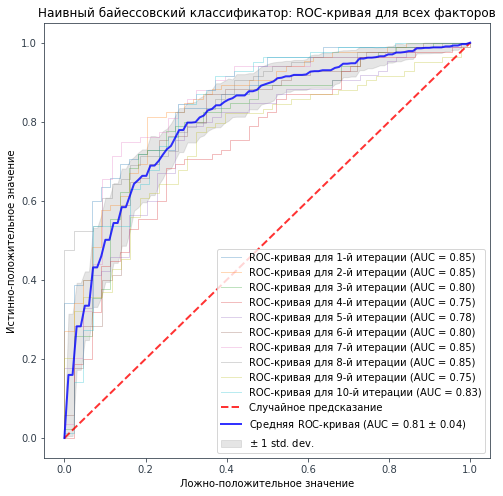

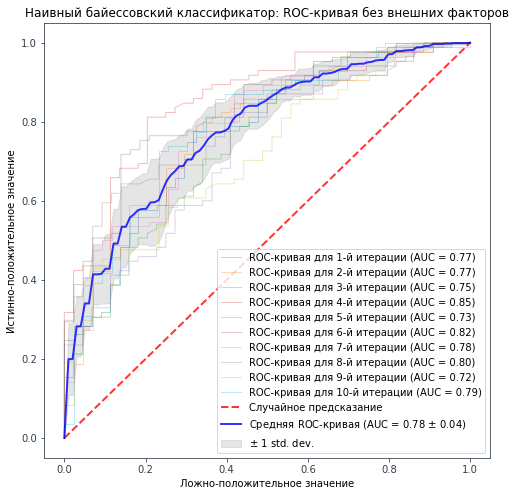

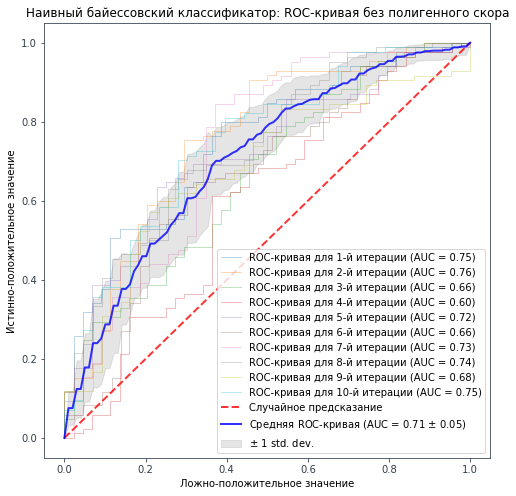

In [60]:
# Naive bayess
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_name = "Наивный байессовский классификатор"
save_name = "naive-bayes"
res = kfold_train_model(gnb, sp_data, df_data, df_target, name=model_name, save_name=save_name)
res_gen = kfold_train_model(gnb, sp_gen_data, df_gen_data, df_gen_target, name=model_name, data="gen", save_name=save_name)
res_non_gen = kfold_train_model(gnb, sp_non_gen_data, df_non_gen_data, df_non_gen_target, name=model_name, data="non-gen", save_name=save_name)

print(res.mean(), res.std())
print(res_gen.mean(), res_gen.std())
print(res_non_gen.mean(), res_non_gen.std())

In [49]:
def draw_3_roc_curves(model, kfold_split_indexes_3, df_data_3, df_target_3, name="Unknown model"):  
    results = []
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(8,8))
    
    factors_3 = [
        "для всех факторов",
        "только для полигенного скора",
        "только для внешних факторов"
    ]
    for factors, kfold_split_indexes, df_data, df_target in zip(factors_3, kfold_split_indexes_3, df_data_3, df_target_3):
        for train_indexes, test_indexes in kfold_split_indexes:
            x_train = df_data.iloc[train_indexes, :]
            y_train = df_target.iloc[train_indexes]
            x_test = df_data.iloc[test_indexes, :]
            y_test =  df_target.iloc[test_indexes]
            model.fit(x_train, y_train)
            predictions = model.predict(x_test)
            results.append(accuracy_score(y_test, predictions))

            predidctions_probs = model.predict_proba(x_test)
            # calculate the fpr and tpr for all thresholds of the classification
            fpr, tpr, threshold = roc_curve(y_test, predidctions_probs[:,1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
        label=r'Средняя ROC-кривая %s (AUC = %0.2f $\pm$ %0.2f)' % (factors, mean_auc, std_auc), lw=2, alpha=0.8)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Случайное предсказание', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Ложно-положительное значение')
    plt.ylabel('Истинно-положительное значение')
    title = "{}: ROC-кривая для трёх случаев обучения".format(name)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(path_join(IMAGES_DIR, "3-roc-curves-bayes.png"))

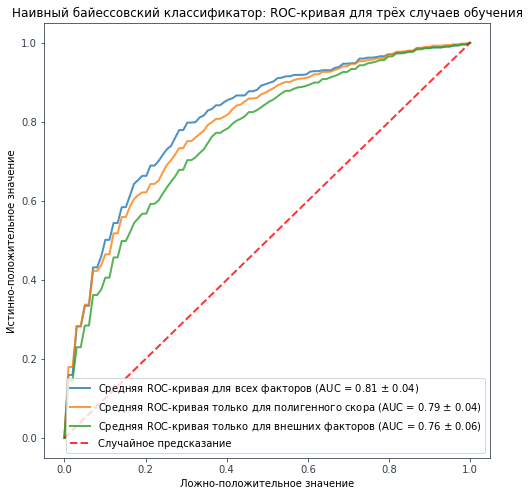

In [50]:
# Naive bayess
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_name = "Наивный байессовский классификатор"

kfold_split_indexes_3 = [sp_data, sp_gen_data, sp_non_gen_data]
df_data_3 = [df_data, df_gen_data, df_non_gen_data]
df_target_3 = [df_target, df_gen_target, df_non_gen_target]

draw_3_roc_curves(gnb, kfold_split_indexes_3, df_data_3, df_target_3, name=model_name)

Пол = 0.050887602759004245
ТГ = 0.21512025126590933
ЛПВП = 0.17763135324189633
ЛПНП = 0.18065534067364172
Скор = 0.3757054520595483
0.7439677371360557 0.023234053008967415


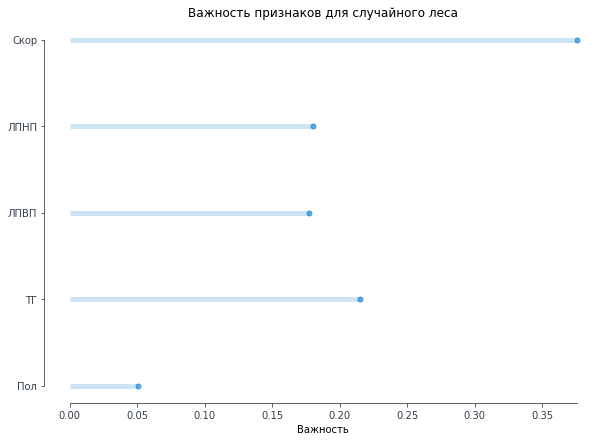

In [37]:
# Feature importances in random forest
def kfold_train_model_features(model, kfold_split_indexes, df_data, df_target):
    results = []
    importances = []
    features = ['Пол', 'ТГ', 'ЛПВП', 'ЛПНП', 'Скор']
    
    for train_indexes, test_indexes in kfold_split_indexes:
        x_train = df_data.iloc[train_indexes, :]
        y_train = df_target.iloc[train_indexes]
        x_test = df_data.iloc[test_indexes, :]
        y_test =  df_target.iloc[test_indexes]
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        results.append(accuracy_score(y_test, predictions))
        
        importances.append(model.feature_importances_)
    
    importances = np.array(importances).mean(axis=0)

    for name, importance in zip(features, importances):
        print(name, "=", importance)
        
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'

    my_range=list(range(1,len(features)+1))
    fig, ax = plt.subplots(figsize=(10,7))
    plt.hlines(y=my_range, xmin=0, xmax=importances, color='#007acc', alpha=0.2, linewidth=5)
    plt.plot(importances, my_range, "o", markersize=5, color='#007acc', alpha=0.6)
    ax.set_xlabel('Важность')
    ax.set_ylabel('')
    
    # set axis
    ax.tick_params(axis='both', which='minor')
    plt.yticks(my_range, features)

    plt.title("Важность признаков для случайного леса")
    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    plt.savefig(path_join(IMAGES_DIR, "feature-importance-random-forest.png"))

    return np.array(results)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)

res = kfold_train_model_features(rf, sp_data, df_data, df_target)

print(res.mean(), res.std())